Данные это выгрузка из нашей аналитики ивентов, связанных с играми.

**Тестовое задание в таком виде:**
- анализ популярности игр среди разных когорт пользователей
- понять кто "наш клиент", а кто "не наш клиент" по по времени, проведённом в играх, по количеству игр и т.д.

# **0. Загрузка нужных библиотек и самого файла с данными.**

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from natsort import index_natsorted
import datetime

# чтобы не получать лишние предупреждения
pd.options.mode.chained_assignment = None

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
df = pd.read_csv('/gdrive/MyDrive/FROM_kids2appevent_3.csv', sep=',', 
                 engine='python')

In [4]:
df

,time,time_iso,platform,device_id,language,app_version,country,learned_words,app_language,session_count,all_words_count,actual_fps,balance,name,duration
0,881175,1970-01-01 00:14:41+00,"""iOS""","""515B0B8E-1703-4850-A5CA-FA09ACE3A00E""","""English""","""2.0.9""",NaN,4.0,NaN,193.0,383.0,NaN,0.0,"""CookiesGameScene""",160.122657
1,929668,1970-01-01 00:15:29+00,"""iOS""","""515B0B8E-1703-4850-A5CA-FA09ACE3A00E""","""English""","""2.0.9""",NaN,4.0,NaN,193.0,383.0,NaN,0.0,"""CookiesGameScene""",47.068588
2,1145056,1970-01-01 00:19:05+00,"""iOS""","""515B0B8E-1703-4850-A5CA-FA09ACE3A00E""","""English""","""2.0.9""",NaN,4.0,NaN,193.0,383.0,NaN,0.0,"""CookiesGameScene""",214.548278
3,1347960,1970-01-01 00:22:27+00,"""iOS""","""515B0B8E-1703-4850-A5CA-FA09ACE3A00E""","""English""","""2.0.9""",NaN,4.0,NaN,193.0,383.0,NaN,0.0,"""CookiesGameScene""",197.668151
4,1405752,1970-01-01 00:23:25+00,"""iOS""","""515B0B8E-1703-4850-A5CA-FA09ACE3A00E""","""English""","""2.0.9""",NaN,4.0,NaN,193.0,383.0,NaN,0.0,"""CookiesGameScene""",55.287820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502219,1628838829777,2021-08-13 07:13:49+00,"""Android""","""dd9fcc3ed9cd606bb9ad50368b134eb7""","""Vietnamese""","""2.0.23""",NaN,0.0,"""Vietnamese""",1.0,490.0,"""60""",11.0,"""PizzaGameScene""",231.601625
1502220,1628838833250,2021-08-13 07:13:53+00,"""Android""","""e9c6772843f6f45cbeb28685c47189cc""","""Korean""","""2.0.23""","""KR""",77.0,"""Korean""",11.0,490.0,"""59""",178.0,"""BathBubblesGameScene""",59.316098
1502221,1628838850980,2021-08-13 07:14:10+00,"""Android""","""464cc2c1fd7c561d1727920c79684c15""","""Vietnamese""","""2.0.23""",NaN,129.0,"""English""",12.0,490.0,"""59""",58.0,"""PizzaGameScene""",162.714276
1502222,1628838851639,2021-08-13 07:14:11+00,"""Android""","""3dbeb57f4f3887ed829555b705dd2c61""","""Vietnamese""","""2.0.23""",NaN,24.0,"""Vietnamese""",17.0,490.0,"""19""",59.0,"""TraceTheLetterGameScene""",101.794198


Первым делом в представленных данных бросается ошибка связанная с данными в 1970 году. Возникает вопрос какие года вообще являются релевантными для данного датасета? Перенесем этот вопрос в очистку данных.

# **1. Предварительная очистка данных.**

Посмотрим общую информацию по сету:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502224 entries, 0 to 1502223
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   time             1502224 non-null  int64  
 1   time_iso         1502224 non-null  object 
 2   platform         1502221 non-null  object 
 3   device_id        1502224 non-null  object 
 4   language         1502224 non-null  object 
 5   app_version      1502224 non-null  object 
 6   country          582456 non-null   object 
 7   learned_words    1497035 non-null  float64
 8   app_language     995669 non-null   object 
 9   session_count    1498527 non-null  float64
 10  all_words_count  1497035 non-null  float64
 11  actual_fps       694597 non-null   object 
 12  balance          1498527 non-null  float64
 13  name             1502224 non-null  object 
 14  duration         1502224 non-null  float64
dtypes: float64(5), int64(1), object(9)
memory usage: 171.9+ MB


Предварительные выводы:
1. В рассматриваем датасете 15 колонок и 150224 строки данных.
2. Основные пропуски располагаются в столбце country, app_language actual_fps.
3. Предположительно NaN в столбцах learned_words, session_count, all_words_count и balance связаны с друг другом. И если их убрать, то останутся только основные пропуски из пункта 2.
4. Формат данных time_iso нужно сменить на datetime
5. Формат данных learned_words и all_words_count после очистки от NaN надо сменить на int64, чтоб быстрее обрабатывались.
6. Формат данных session_count и balance пока не известен, возможно надо будет оставить float64.
7. Формат данных actual_fps тоже надо исправить на int64. 
8. Какие года в time_iso релевантны для данного проекта и что стоит очистить? Ошибка 1970 года.


**1.1 Выполним предположение об очистке данных из пункта 3:** 

In [6]:
df = df.dropna(subset=['learned_words', 'all_words_count'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497035 entries, 0 to 1502223
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   time             1497035 non-null  int64  
 1   time_iso         1497035 non-null  object 
 2   platform         1497032 non-null  object 
 3   device_id        1497035 non-null  object 
 4   language         1497035 non-null  object 
 5   app_version      1497035 non-null  object 
 6   country          582456 non-null   object 
 7   learned_words    1497035 non-null  float64
 8   app_language     990480 non-null   object 
 9   session_count    1497035 non-null  float64
 10  all_words_count  1497035 non-null  float64
 11  actual_fps       689543 non-null   object 
 12  balance          1497035 non-null  float64
 13  name             1497035 non-null  object 
 14  duration         1497035 non-null  float64
dtypes: float64(5), int64(1), object(9)
memory usage: 182.7+ MB


Как мы видим остались только пропуски в колонках: country, app_language, actual_fps.

**1.2 Посмотрим на уникальные значения столбца all_words_count и сменим формат данных learned_words и all_words_count на int64.**


In [8]:
df['all_words_count'].unique()

array([383., 414., 470., 490., 352., 473., 388., 351., 372., 370., 384.,
       464., 467., 465.,   0.])

In [9]:
df['all_words_count'] = df['all_words_count'].astype('int64')
df['learned_words'] = df['learned_words'].astype('int64')

**1.3 В строковых переменных значения заключены в кавычки, уберем их. Также заменим формат данных actual_fps на int64.**

In [10]:
list_columns_quote = ['platform', 'device_id', 'language', 'app_version', 
                      'country', 'app_language', 'actual_fps', 'name']

Пройдемся циклом и удалим кавычки из списка выше.

In [11]:
for column in list_columns_quote:
  df[column] = [element_in_fps.replace('"','')
                if type(element_in_fps) == str 
                else element_in_fps
                for element_in_fps in df[column]]

После этого сменим формат данных actual_fps на float64, так как в данном столбце сохраняются NaN.

In [12]:
df['actual_fps'] = df['actual_fps'].astype('float64')

**1.4 Сменим формат time_iso на datetime. И оценим какие года релевантны для данного проекта. Уберем ошибку 1970 года.**

In [13]:
df['time_iso'] = pd.to_datetime(df['time_iso'])

In [14]:
df['year'] = df['time_iso'].dt.year

Посмотрим какие года представлены в датасете:

In [15]:
df.year.value_counts()

2021    1009125
2020     483043
2015       4550
2018        149
2008         48
2010         31
2012         28
1970         24
2016         18
2009         16
2013          3
Name: year, dtype: int64

In [16]:
round((len(df[df['year'] == 2021]) + len(df[df['year'] == 2020]) 
                                          ) / len(df) * 100, 2)

99.67

Как видим более 99% данных получены в 2020 и 2021. Поэтому очистим датасет от ненужных данных.

In [17]:
df = df[df['year'] >= 2020]

Также добавим столбцы для дня недели, месяца и часа.

In [18]:
df['weekday'] = df['time_iso'].dt.day_name()
df['hour'] = df['time_iso'].dt.hour
df['month'] = df['time_iso'].dt.month

# **2. Есть ли выбросы в данных.**

In [19]:
df.describe()

,time,learned_words,session_count,all_words_count,actual_fps,balance,duration,year,hour,month
count,1.492168e+06,1.492168e+06,1.492168e+06,1.492168e+06,689403.000000,1.492168e+06,1.492168e+06,1.492168e+06,1.492168e+06,1.492168e+06
mean,1.615241e+12,2.217014e+01,2.058997e+01,4.510971e+02,70.240576,6.957662e+01,9.789146e+01,2.020676e+03,1.181993e+01,6.649792e+00
std,1.068060e+10,3.961296e+01,3.036188e+01,4.363708e+01,1016.528163,1.474672e+02,2.806870e+02,4.678944e-01,5.396568e+00,3.083757e+00
min,1.594587e+12,0.000000e+00,1.000000e+00,0.000000e+00,9.000000,-2.190000e+02,0.000000e+00,2.020000e+03,0.000000e+00,1.000000e+00
25%,1.606236e+12,0.000000e+00,3.000000e+00,4.140000e+02,58.000000,4.000000e+00,8.708354e+00,2.020000e+03,8.000000e+00,5.000000e+00
50%,1.615872e+12,8.000000e+00,1.000000e+01,4.730000e+02,59.000000,2.100000e+01,5.517509e+01,2.021000e+03,1.200000e+01,7.000000e+00
75%,1.625489e+12,2.400000e+01,2.500000e+01,4.900000e+02,60.000000,7.200000e+01,1.224281e+02,2.021000e+03,1.600000e+01,8.000000e+00
max,1.628839e+12,4.140000e+02,1.546000e+03,4.900000e+02,100000.000000,4.123000e+03,2.331162e+05,2.021000e+03,2.300000e+01,1.200000e+01


**Выводы:**
1. В столбце количества выученных слов есть значение 414, хотя 75% всех учеников осилили 24 слова.
2. В столбце данных о фпс есть значение 100000, что явно является выбросом для учета данных mean+-3*std.
3. В столбце баланс монеток также выброс в виде значения 4123.
4. В столбце длительность есть выброс 233116.2.


Так как стартово нет развернутого описания столцов, то эти выбросы могут быть связаны с недопониманием. Поэтому проверим, какие данные входят в 99%.

In [20]:
df["learned_words"].quantile(0.99)

208.0

In [21]:
df['session_count'].quantile(0.995)

186.0

In [22]:
df['actual_fps'].quantile(0.995)

265.0

In [23]:
df['balance'].quantile(0.99)

625.0

In [24]:
df['duration'].quantile(0.995)

957.3745223768278

Как видно из полученных цифр, имеет смысл ограничить столбцы:
session_count и duration.
Столбец с данными о фпс нет смысла ограничивать, так он не несет важной информации и имеет множество пропусков.
Для ограничения столбцов с выученными словами и монетками нет явных причин, так как предположительно это те пользователи, которые постарались закончить курс.


In [25]:
df = df[(df['session_count'] <= df['session_count'].quantile(0.995)) & 
        (df['duration'] <= df['duration'].quantile(0.995))]

In [26]:
df.describe()

,time,learned_words,session_count,all_words_count,actual_fps,balance,duration,year,hour,month
count,1.477302e+06,1.477302e+06,1.477302e+06,1.477302e+06,680580.000000,1.477302e+06,1.477302e+06,1.477302e+06,1.477302e+06,1.477302e+06
mean,1.615195e+12,2.193672e+01,1.955667e+01,4.509918e+02,70.423940,6.927250e+01,8.986740e+01,2.020675e+03,1.182081e+01,6.647948e+00
std,1.069042e+10,3.923010e+01,2.646257e+01,4.365025e+01,1023.086959,1.470225e+02,1.192050e+02,4.683896e-01,5.394511e+00,3.087954e+00
min,1.594587e+12,0.000000e+00,1.000000e+00,0.000000e+00,9.000000,-2.190000e+02,0.000000e+00,2.020000e+03,0.000000e+00,1.000000e+00
25%,1.606215e+12,0.000000e+00,3.000000e+00,4.140000e+02,58.000000,4.000000e+00,8.602701e+00,2.020000e+03,8.000000e+00,5.000000e+00
50%,1.615739e+12,8.000000e+00,1.000000e+01,4.730000e+02,59.000000,2.100000e+01,5.468824e+01,2.021000e+03,1.200000e+01,7.000000e+00
75%,1.625475e+12,2.400000e+01,2.400000e+01,4.900000e+02,60.000000,7.200000e+01,1.213071e+02,2.021000e+03,1.600000e+01,8.000000e+00
max,1.628839e+12,4.140000e+02,1.860000e+02,4.900000e+02,100000.000000,4.123000e+03,9.573598e+02,2.021000e+03,2.300000e+01,1.200000e+01


# **3. Общие факты о данных.**

# **3.1 Распределения захода в приложение в течения дня.**

Для этого построим сводную таблицу, показывающую количество заходов в приложение для каждого часа:

In [27]:
table_time = df.pivot_table(index='hour', values='platform', 
                            aggfunc='count').reset_index()
table_time

,hour,platform
0,0,21935
1,1,25216
2,2,30392
3,3,35472
4,4,43691
5,5,51293
6,6,69566
7,7,72445
8,8,77356
9,9,79646


И построим ее в виде столбчатого графика.

In [28]:
px.bar(table_time, x='hour', y='platform')

Так как приложение ориентировано на детей, то пик активности приходится на время после школы 14-15 часов, начиная с 20 до 6 утра активность минимальна. 

# **3.2 Данные о языках в приложении.**

В данных есть два столбца описывающие языки. Предположим, что так как данные language полные, то предположительно это является столбцом, описывающим какой языв изучает юзер. А данные app_language это данные о языке интерфейса. Посмотрим на сами значения и их распределение.

In [29]:
df.language.value_counts()

Russian               621597
English               250091
Turkish               116590
Spanish               107556
Indonesian             91860
Vietnamese             56170
Ukrainian              44696
Arabic                 24480
Portuguese             18438
Unknown                18067
Korean                 16329
Romanian               12821
Polish                 11839
French                  9297
SerboCroatian           8307
Italian                 8057
Greek                   6916
Thai                    6564
German                  6362
Hungarian               5335
Czech                   5228
ChineseTraditional      4195
Hebrew                  3951
Lithuanian              3834
Japanese                3773
Bulgarian               2512
ChineseSimplified       2407
Slovak                  2019
Latvian                 1737
Dutch                   1416
Finnish                  962
Slovenian                794
Danish                   678
Estonian                 587
Norwegian     

In [30]:
df.app_language.value_counts()

Russian               380163
English               295885
Indonesian             65216
Spanish                52978
Ukrainian              52135
Vietnamese             27067
Korean                 17969
Portuguese              9991
Arabic                  9474
Romanian                7699
Turkish                 6938
Polish                  6220
SerboCroatian           5542
Italian                 5006
French                  4246
Greek                   3868
Unknown                 3507
Hungarian               3181
Czech                   2637
Lithuanian              2592
Hebrew                  2440
ChineseTraditional      1999
Japanese                1903
Bulgarian               1825
Thai                    1177
Latvian                 1107
German                  1080
Slovak                  1075
ChineseSimplified        822
Slovenian                571
Danish                   460
Dutch                    455
Estonian                 441
Swedish                  339
Finnish       

Топ 5 изучаемых языков это: Russian, English, Turkish,Spanish,Indonesian. На остальные языки остается 26% от всех данных.

# **4. Анализ популярности игр среди разных когорт пользователей**

Определим событие регистрации игрока, или его первый вход, как минимальное время для каждого из уникальных device_id.
Для этого построим сводную таблицу:

In [31]:
table_id_time = df.pivot_table(index='device_id', values='time_iso', 
                               aggfunc='min').reset_index()
table_id_time.head(1)

,device_id,time_iso
0,0001876f85c02ff391b0d92fd03f680f,2020-11-04 17:03:07+00:00


Так как мы рассматриваем два года, то для уточнения нам нужно сохранить год и месяц входа в игру, сформируем из них общий столбец.

In [32]:
table_id_time['month'] = table_id_time['time_iso'].dt.month
table_id_time['year'] = table_id_time['time_iso'].dt.year
table_id_time.head(1)

,device_id,time_iso,month,year
0,0001876f85c02ff391b0d92fd03f680f,2020-11-04 17:03:07+00:00,11,2020


In [33]:
table_id_time['reg_year_month'] = [str(table_id_time.loc[el, 'year']) + ' ' 
                                   + str(table_id_time.loc[el, 'month'])
                                   for el in range(len(table_id_time))]

In [34]:
result_table_id_time = table_id_time

In [35]:
del result_table_id_time['time_iso']
del result_table_id_time['year']
del result_table_id_time['month']

Таким образом мы получаем два связанных столбца, это уникальный device_id и год и месяц его первого захода в игру.

In [36]:
result_table_id_time.head(1)

,device_id,reg_year_month
0,0001876f85c02ff391b0d92fd03f680f,2020 11


Добавим в исходный датафрейм полученные данные, смёрджив таблицы.

In [37]:
df = pd.merge(df, result_table_id_time, how='left')

Создадим аналогичную колонку с месяцем и годом для всех входов в игру.

In [38]:
df['year_month'] = [str(df.loc[el, 'year']) + ' ' + str(df.loc[el, 'month'])
                    for el in range(len(df))]

Так как мы рассматриваем события в течение двух лет, то нас интересует отдельно сколько месяцев пользователь пользуется приложением, для этого создадим функцию.

In [39]:
def lifetime(row, df, min, max):
  year_max = int(df.loc[row, max][:4])
  year_min = int(df.loc[row, min][:4])
  difference_year = year_max - year_min

  max_month = int(df.loc[row, max][5:])
  min_month = int(df.loc[row, min][5:])
  difference_month = max_month - min_month

  if difference_year == 0:
    return difference_month + 1
  else:
    return difference_year * 12 + difference_month + 1

In [40]:
df['lifetime'] = [lifetime(row, df, 'reg_year_month', 'year_month')
                  for row in range(len(df))]

In [41]:
df.lifetime.value_counts()

1     961963
2     307491
3      89179
4      44413
5      24350
6      15838
7      12069
8       7424
9       4703
10      4005
11      3471
12      1840
13       437
14       119
Name: lifetime, dtype: int64

Таким образом мы получаем эффективность мобильных приложений, сколько людей остается увлеченным приложением с течением времени.

In [42]:
table_retention = df.pivot_table(index='reg_year_month', columns='lifetime',
                                 values='device_id',
                                 aggfunc= 'nunique').reset_index()
table_retention

lifetime,reg_year_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2020 10,2273.0,643.0,386.0,270.0,139.0,56.0,59.0,36.0,75.0,76.0,34.0,NaN,NaN,NaN
1,2020 11,1904.0,524.0,304.0,163.0,78.0,67.0,43.0,64.0,67.0,41.0,NaN,NaN,NaN,NaN
2,2020 12,1343.0,379.0,179.0,63.0,57.0,29.0,55.0,44.0,29.0,NaN,NaN,NaN,NaN,NaN
3,2020 7,897.0,207.0,62.0,49.0,34.0,29.0,28.0,15.0,8.0,6.0,7.0,16.0,18.0,8.0
4,2020 8,1372.0,179.0,104.0,83.0,61.0,59.0,32.0,10.0,11.0,9.0,16.0,18.0,6.0,NaN
5,2020 9,2122.0,497.0,340.0,249.0,192.0,82.0,37.0,34.0,23.0,33.0,62.0,31.0,NaN,NaN
6,2021 1,3350.0,889.0,195.0,131.0,97.0,159.0,173.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2021 2,1225.0,185.0,94.0,66.0,71.0,82.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021 3,472.0,175.0,85.0,64.0,70.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021 4,246.0,75.0,45.0,51.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Необходимо отсортировать полученную таблицу по году и месяцу, для этого воспользуемся функцией index_natsorted

In [43]:
def natsorted(table, column):
  return table.sort_values(
                        by=column,
                        key=lambda x: np.argsort(index_natsorted(
                            table[column]))
                        )

In [44]:
table_retail = natsorted(table_retention, 'reg_year_month'
                          ).reset_index(drop=True)

In [45]:
table_retail.columns.names = ['']

In [46]:
table_retail.head(1)

,reg_year_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2020 7,897.0,207.0,62.0,49.0,34.0,29.0,28.0,15.0,8.0,6.0,7.0,16.0,18.0,8.0


Построим Retention Rate для полученных данных о пользователях. То есть считаем процент тех пользователей кто остался в приложении по сравнению со стартовым числом юзеров.

In [47]:
for column in range(2,15):
  for row in range(14):
    table_retail.loc[row, column] = round(table_retail.loc[row, column] / 
                                         table_retail.loc[row, 1], 2)

In [48]:
for row in range(14):
  table_retail.loc[row, 1] = 1

In [49]:
table_retail

,reg_year_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2020 7,1.0,0.23,0.07,0.05,0.04,0.03,0.03,0.02,0.01,0.01,0.01,0.02,0.02,0.01
1,2020 8,1.0,0.13,0.08,0.06,0.04,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.00,NaN
2,2020 9,1.0,0.23,0.16,0.12,0.09,0.04,0.02,0.02,0.01,0.02,0.03,0.01,NaN,NaN
3,2020 10,1.0,0.28,0.17,0.12,0.06,0.02,0.03,0.02,0.03,0.03,0.01,NaN,NaN,NaN
4,2020 11,1.0,0.28,0.16,0.09,0.04,0.04,0.02,0.03,0.04,0.02,NaN,NaN,NaN,NaN
5,2020 12,1.0,0.28,0.13,0.05,0.04,0.02,0.04,0.03,0.02,NaN,NaN,NaN,NaN,NaN
6,2021 1,1.0,0.27,0.06,0.04,0.03,0.05,0.05,0.03,NaN,NaN,NaN,NaN,NaN,NaN
7,2021 2,1.0,0.15,0.08,0.05,0.06,0.07,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021 3,1.0,0.37,0.18,0.14,0.15,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021 4,1.0,0.30,0.18,0.21,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим heatmap для полученных значений, а также добавим среднее значение.

In [50]:
retention_table = table_retail
del retention_table['reg_year_month'] 

In [51]:
retention_table

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,0.23,0.07,0.05,0.04,0.03,0.03,0.02,0.01,0.01,0.01,0.02,0.02,0.01
1,1.0,0.13,0.08,0.06,0.04,0.04,0.02,0.01,0.01,0.01,0.01,0.01,0.00,NaN
2,1.0,0.23,0.16,0.12,0.09,0.04,0.02,0.02,0.01,0.02,0.03,0.01,NaN,NaN
3,1.0,0.28,0.17,0.12,0.06,0.02,0.03,0.02,0.03,0.03,0.01,NaN,NaN,NaN
4,1.0,0.28,0.16,0.09,0.04,0.04,0.02,0.03,0.04,0.02,NaN,NaN,NaN,NaN
5,1.0,0.28,0.13,0.05,0.04,0.02,0.04,0.03,0.02,NaN,NaN,NaN,NaN,NaN
6,1.0,0.27,0.06,0.04,0.03,0.05,0.05,0.03,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,0.15,0.08,0.05,0.06,0.07,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.37,0.18,0.14,0.15,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.30,0.18,0.21,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим среднее значения полученного Retention rate для каждого из столбцов.

In [52]:
retention_table.loc['mean', :] = [retention_table[row].mean()
                                  for row in range(1, 15, 1)]

# **Выводы для пункта 4.**

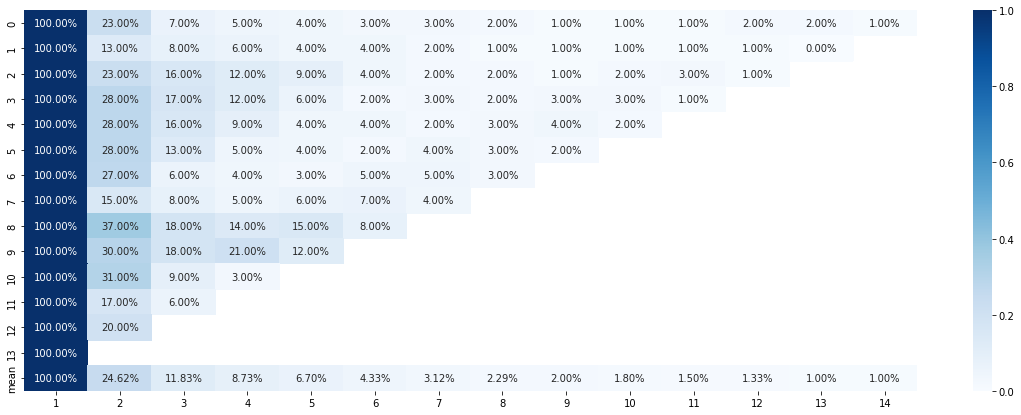

In [53]:
plt.figure(figsize=(20, 7))
sns.heatmap(retention_table, annot=True, fmt='.2%', cmap='Blues')

Мы разделили пользователей на когорты по месяцам первого захода в приложение, дальше учитывали тех пользователей,которые пользовались приложением в течение следующих месяцев. 
Столбцы показывают, как менялся Retention Rate для каждой когорты от недели к неделе. Чем выше показатель, тем темнее цвет ячейки.
Последняя строка показывает среднее значение Retention Rate начиная с момента первого захода в приложение и для каждого последующего месяца.

Выводы:
1. Уже со второго месяца процент оставшихся юзеров уменьшается в среднем в 4 раза.
2. Затем постепенно уменьшается до 2-3% в течение первых 6 месяцев.
3. С седьмого месяца остается в среднем от 1 до 2 процентов пользователей.
4. Видно, что минимальный Retention Rate достигался в августе 2020 и в феврале 2021 года. 
5. Максимум сохранения пользователей был в марте-мае 2021 года. Возможно это связано с рекламой или с какими-то ивентами.
6. Для пользователей зашедших первый раз в приложение в апреле 2021 года возникла аномалия, что часть пользователей вернулась на третьем месяце.

# **5. Выделение типа игр по времени их выхода.**

Разделим игры по длительности их нахождения в приложении. Для этого построим таблицу с минимум и максимум месяца и года их появления.

In [54]:
table_interval_name = df.pivot_table(index='name', values='time_iso', 
                                     aggfunc=['min','max']).reset_index()
table_interval_name.rename(columns = {'year_month': 'min'}, inplace = True)
table_interval_name.columns = table_interval_name.columns.droplevel()
table_interval_name.columns = ['name', 'min', 'max']
table_interval_name.head(1)

,name,min,max
0,AnimalsSpinGameScene,2020-07-13 04:56:42+00:00,2021-08-13 06:23:08+00:00


In [55]:
for column in ['min', 'max']:
  table_interval_name['year_' + column] = table_interval_name[column].dt.year
  table_interval_name['month_' + column] = table_interval_name[column].dt.month
  table_interval_name['year_month_' + column] = [str(
      table_interval_name.loc[el, 'year_' + column]) + ' ' + str(
          table_interval_name.loc[el, 'month_' + column])
                    for el in range(len(table_interval_name))]

In [56]:
table_interval_name.head(1)

,name,min,max,year_min,month_min,year_month_min,year_max,month_max,year_month_max
0,AnimalsSpinGameScene,2020-07-13 04:56:42+00:00,2021-08-13 06:23:08+00:00,2020,7,2020 7,2021,8,2021 8


Объединим данные таблицы в одну и вычислим суммарное время жизни этой игры в приложении.

In [57]:
table_interval_name = table_interval_name[['name', 'year_month_min', 
                                           'year_month_max']]

In [58]:
table_interval_name['interval'] = [lifetime(row, table_interval_name,
                                             'year_month_min', 'year_month_max')
                                  for row in range(len(table_interval_name))]
                                  
table_interval_name = table_interval_name.sort_values(by='interval', 
                                                      ascending=False
                                                      ).reset_index()

Таким образом мы получили:

In [59]:
table_interval_name

,index,name,year_month_min,year_month_max,interval
0,0,AnimalsSpinGameScene,2020 7,2021 8,14
1,30,PuzzleDumbGameScene,2020 7,2021 8,14
2,23,MemoryGameScene,2020 7,2021 8,14
3,24,PaintLetterGameScene,2020 7,2021 8,14
4,25,PazzleLettersGameScene,2020 7,2021 8,14
5,1,ArchaeologyGameScene,2020 7,2021 8,14
6,27,PickUpDriverGameScene,2020 7,2021 8,14
7,28,PizzaGameScene,2020 7,2021 8,14
8,32,RiverGameScene,2020 7,2021 8,14
9,18,GalleryPresentationGameScene,2020 7,2021 8,14


In [60]:
table_interval_name['year_month_max'].value_counts()

2021 8    50
2021 7     1
2020 9     1
Name: year_month_max, dtype: int64

Как видно из таблицы:
1. Основная часть игр это старые игры, которые активны 14-12 месяцев.
2. 9 новых игр. Появившиеся за последние месяцы (1-3 месяца).
3. SongsMenuScene была запущена и закончена в сентябре 2020 года.
5. MainModeScene завершили в июле 2021.

Сформируем из данных 3 листа игр:
1. Старые
2. Новые
3. Исключения


In [61]:
list_name_old = list(table_interval_name.name)[:-9]
list_name_new = list(table_interval_name.name)[-9:]
list_name_new.remove('SongsMenuScene')
list_name_old.remove('MainModeScene')
list_name_exception = ['MainModeScene', 'SongsMenuScene']

In [62]:
list_name_new

['RackGameScene',
 'TamagotchiScene',
 'SeasonsDressingGameScene',
 'SoapBubblesGameScene',
 'SortingSize',
 'SeasonsGameScene',
 'TransportSorting',
 'BirthdayGameScene']

Добавим в стартовый датафрейм колонку описывающую в какой тип игр играет пользователь.

In [63]:
df['name_type'] = ['old'
                   if df.loc[row, 'name'] in list_name_old
                   else 'exception'
                   if df.loc[row,'name'] in list_name_exception
                   else 'new'
                   for row in range(len(df))]

# **6. Распределение пользователей по типам игр и для каждой игры в отдельности.**

Разделим всех пользователей по времени их регистрации и для каждого месяца посмотрим в какой тип игр они играют.

In [64]:
table_type_all = df.pivot_table(index=['reg_year_month', 'name_type'], 
                                values='device_id', 
                                aggfunc='nunique', fill_value=0
                                ).reset_index()
table_type_all = natsorted(table_type_all, 'reg_year_month'
                            ).reset_index(drop=True)
table_type_all

,reg_year_month,name_type,device_id
0,2020 7,exception,403
1,2020 7,new,7
2,2020 7,old,896
3,2020 8,exception,576
4,2020 8,new,8
5,2020 8,old,1362
6,2020 9,exception,331
7,2020 9,new,17
8,2020 9,old,2114
9,2020 10,exception,36


In [65]:
table_type_all['reg_year_month'] = [datetime.datetime(year=int(
    table_type_all.loc[row, 'reg_year_month'][:4]), 
                                                      month=int(
    table_type_all.loc[row, 'reg_year_month'][4:]), 
                                                      day=1)
                                   for row in range(len(table_type_all))]

In [66]:
table_type_all

,reg_year_month,name_type,device_id
0,2020-07-01,exception,403
1,2020-07-01,new,7
2,2020-07-01,old,896
3,2020-08-01,exception,576
4,2020-08-01,new,8
5,2020-08-01,old,1362
6,2020-09-01,exception,331
7,2020-09-01,new,17
8,2020-09-01,old,2114
9,2020-10-01,exception,36


Построим столбчатую диаграмму для полученной таблицы, цветом выделим тип игр.

In [67]:
px.bar(table_type_all, x='reg_year_month', y='device_id', color='name_type')

Посмотрим отдельно на новые игры, так как их процент слишком мал и они теряются на фоне старых.


In [68]:
px.bar(table_type_all[table_type_all['name_type'] == 'new'], x='reg_year_month', 
       y='device_id')

**Выводы**
1. Изначальный рост активности пользователей был плавным и достиг пика в сентябре 2020.
2. Второй пик был резким в январе 2021. Возможно связан с рекламой или какими-то ивентами.
3. Третий пик был резким в июле 2021 года. Также возможно связан с рекламой или с введением новых особенностей в игре.
4. Также стоит отметить, что новые добавленные вещи не пользуются популярностью.

Помимо выводов выведем статистику сколько пользователей играло в те или иные виды игр.

In [69]:
for nametype in ['old', 'exception', 'new']:
  print('В играх типа', nametype, 'принимало участие', 
        len(df[df['name_type'] == nametype].device_id.unique()),
        'пользователей.')

В играх типа old принимало участие 43280 пользователей.
В играх типа exception принимало участие 1355 пользователей.
В играх типа new принимало участие 3142 пользователей.


# **6.2 Топ игр по популярности у пользователей.**

Как видно было в разделе 6.1 основной популярностью пользуются старые игры. Выведем топ игр по участию в них уникальных пользователей.


In [70]:
table_game_unique_id = df.pivot_table(index=['name', 'name_type'], 
                                      values='device_id', aggfunc=['nunique', 
                                                                   'count'], 
                                      fill_value=0
                                      ).reset_index()
table_game_unique_id.columns = table_game_unique_id.columns.droplevel()
table_game_unique_id.columns = ['name', 'name_type', 'nunique', 'count']

In [71]:
table_top_name_unique = table_game_unique_id.sort_values(by='nunique', 
                                                      ascending=False
                                                      ).head(10)
table_top_name_count = table_game_unique_id.sort_values(by='count', 
                                                      ascending=False
                                                      ).head(10)

Выведем топ 10 игр, в которые играло большинство пользователей:

In [72]:
table_top_name_unique

,name,name_type,nunique,count
10,CookiesGameScene,old,16693,166977
35,RunnerGameScene,old,16602,95604
39,SimpleMathGameScene,old,15727,70713
16,FruitDishGameScene,old,15602,83011
48,TraceTheNumberGameScene,old,14147,54519
9,Coloring2GameScene,old,14071,80773
28,PizzaGameScene,old,9567,86474
1,ArchaeologyGameScene,old,9244,65597
50,WashYourHandsGameScene,old,8507,66606
3,BathBubblesGameScene,old,8267,36340


Выведем топ 10 игр, в которые играло чаще всего заходили пользователи:

In [73]:
table_top_name_count

,name,name_type,nunique,count
10,CookiesGameScene,old,16693,166977
35,RunnerGameScene,old,16602,95604
28,PizzaGameScene,old,9567,86474
16,FruitDishGameScene,old,15602,83011
9,Coloring2GameScene,old,14071,80773
39,SimpleMathGameScene,old,15727,70713
8,CleanRoomGameScene,old,5868,69121
50,WashYourHandsGameScene,old,8507,66606
1,ArchaeologyGameScene,old,9244,65597
6,BrushYourTeethGameScene,old,5619,63307


In [74]:
list_top_name_count = list(table_top_name_count.name.head(10))
list_top_name_unique = list(table_top_name_unique.name.head(10))

Стоит отметить, что 8 игр из этих список повторяются. То есть данные игры и в топе по посещаемости и большинство их попробовали.

In [75]:
result = list(set(list_top_name_count) & set(list_top_name_unique))
result

['PizzaGameScene',
 'RunnerGameScene',
 'Coloring2GameScene',
 'SimpleMathGameScene',
 'WashYourHandsGameScene',
 'CookiesGameScene',
 'ArchaeologyGameScene',
 'FruitDishGameScene']

Также стоит отметить те игры, которые набрали очень мало пользователей:

In [76]:
table_game_unique_id.sort_values(by='nunique', ascending=True).head(10)

,name,name_type,nunique,count
42,SongsMenuScene,exception,1,2
37,SeasonsGameScene,new,1,7
43,SortingSize,new,2,18
36,SeasonsDressingGameScene,new,3,33
5,BirthdayGameScene,new,3,16
41,SoapBubblesGameScene,new,5,14
49,TransportSorting,new,6,28
45,TamagotchiScene,new,14,73
29,PutOnPajamasGameScene,old,18,50
32,RiverGameScene,old,546,2048


Видно, что последние 9 игр самые непопулярные, количество зашедших в них пользователей резко спадает до 1-18 пользователей.

# **7. Распределение пользователей по странам, по типу платформ, по среднему времени сессии, по выученным словам.**

Посмотрим на разделение пользователей по странам, а также по платформам. Выделим аномалии, если они есть.

# **7.1 Распределение пользователей по странам.**

Построим таблицу сводных значений для статистики стран для каждого уникального пользователя.

In [77]:
table_country = df.pivot_table(index='country', values='device_id', 
                               aggfunc='nunique').reset_index().sort_values(
                                by='device_id', ascending=False)

Добавим в таблицу процентное соотношение пользователей из той или иной страны к общему числу пользователей.

In [78]:
table_country.loc['sum', :] = ['sum' if column == 0
                                else table_country['device_id'].sum()
                           for column in range(2)]
table_country.loc['all', :] = ['all' if column == 0
                                else len(df['device_id'].unique())
                           for column in range(2)]  
table_country['sum_'] = [len(df['device_id'].unique())
                            for row in range(10)]
table_country['percent'] = round(table_country['device_id'] / 
                                 table_country['sum_'] * 100, 2)  
del table_country['sum_']                    

In [79]:
table_country.reset_index(drop=True)

,country,device_id,percent
0,UNKNOWN,17330.0,39.96
1,RU,4761.0,10.98
2,UA,2616.0,6.03
3,MX,755.0,1.74
4,KZ,639.0,1.47
5,BR,620.0,1.43
6,DE,518.0,1.19
7,KR,457.0,1.05
8,sum,27696.0,63.86
9,all,43370.0,100.00


1. 76% всех позователей или имеет пропуск в данных о стране, или указаны как с неизвестной страны
2. Основная часть клиентов приходится на Россию (11%) и Украину (6%)
3. Пользователи остальных стран представлены в данном сете от 1 до 2%.

**Вывод**
 Можно считать, что основной клиент это русский и украинский рынки.

# **7.2 Распределение пользователей по платформам.**

Помимо распределения пользователей по платформам, стоит учесть какая платформа популярна в той или иной стране. 

In [80]:
table_country_device = df.pivot_table(index=['country', 'platform'], 
                                      values='device_id', aggfunc='nunique'
                                      ).reset_index()

In [81]:
table_country_device.loc['sum', :] = ['sum' if column in ['country', 'platform'] 
                                else table_country_device['device_id'].sum()
                           for column in list(table_country_device.columns)]
table_country_device.loc['all', :] = ['all' if column in ['country', 'platform'] 
                                else len(df['device_id'].unique())
                           for column in list(table_country_device.columns)]  
table_country_device['sum_'] = [ len(df['device_id'].unique())
                            for row in range(len(table_country_device))]
table_country_device['percent'] = round(table_country_device['device_id'] / 
                                 table_country_device['sum_'] * 100, 2)  
del table_country_device['sum_']  
table_country_device = table_country_device.reset_index(drop=True)

In [82]:
table_country_device

,country,platform,device_id,percent
0,BR,Android,607.0,1.40
1,BR,iOS,13.0,0.03
2,DE,Android,504.0,1.16
3,DE,iOS,14.0,0.03
4,KR,Android,442.0,1.02
5,KR,iOS,15.0,0.03
6,KZ,Android,442.0,1.02
7,KZ,iOS,197.0,0.45
8,MX,Android,652.0,1.50
9,MX,iOS,103.0,0.24


In [83]:
fig = px.bar(table_country_device, x='country', y='percent', color='platform')
fig.show()

**Выводы**
1. Во всех странах превалируют пользователи android.
2. В  России процент пользователей платформой iOS выше, чем в остальных странах (2%). 

# **7.3 Распределение пользователей по среднему времени в игре.**

Построим сводную таблицу для данных по уникальным пользователям для каждой из платформ и для среднего времени сессии.

In [84]:
df.pivot_table(index='platform', values='duration', aggfunc='median'
).reset_index()

,platform,duration
0,Android,69.263245
1,iOS,33.634604


In [85]:
table_duration = df.pivot_table(index=['device_id', 'platform'], 
                                values='duration', aggfunc='median'
                                ).reset_index()
table_duration

,device_id,platform,duration
0,0001876f85c02ff391b0d92fd03f680f,Android,194.794866
1,0001a5b8decb177c015e43b4fd2ef935,Android,38.607770
2,0002db1cf1550d4214e0198106df4af4,Android,30.303248
3,0003efbf15e447bc1098757254b8370f,Android,182.374443
4,00044a4626940dfd4766352bd6fecdd0,Android,75.672667
...,...,...,...
43365,fff8ec959d30121fc568b9263b13ccc9,Android,52.186840
43366,fffb27ff85844eb4ab350142b2fac9b2,Android,92.120461
43367,fffd7c24b3e85f9825f1bd741291417b,Android,32.047103
43368,fffdc5d451ab7b8d06ade98b52ca872b,Android,55.307937


Для удобства понимания данных построим "ящик с усами", и гистограмму для каждой из платформ.

In [86]:
px.box(table_duration, y='duration', color='platform')

In [87]:
px.histogram(table_duration, x='duration', color='platform')

1. Среднее время проведенное в приложении для пользователя андроид и иос составляет 78 и 38 соответственно.
2. Основная часть пользователей не задерживается больше 228 минут и 130 минут для андроид и иос соответственно.
3. Больше 25% всех пользователей проводит в приложении больше 42 минут и 20 минут для андроид и иос соответственно.
4. Из гистограмм видно, что первый пик времени проведенного в игре составляет 2.5-7.5 минут. Значит можно считать, что это минимум времени нужного на сессию.

**Вывод:**

Можно считать пользователя увлеченным, если он проводит в приложении больше 42 минут и 20 минут для андроид и иос соответственно. 

А для ознакомления с продуктом нужно 2.5-7.5 минут.


# **7.4 Распределение пользователей по количеству выученных слов за сессию.**

Разделим этот вопрос на несколько частей:
1. Какое среднее значения выученных слов для пользователей?
2. Меняется ли это значение в зависимости от языков?


In [88]:
table_learned_words = df.pivot_table(index='device_id', values='learned_words', 
                                     aggfunc='mean').reset_index()

In [89]:
px.box(table_learned_words, y='learned_words')

In [90]:
table_learned_words['learned_words'].quantile(0.50)

0.8333333333333334

**Выводы:**
1. 90% пользователей за сессию в среднем учат до 12 слов.
2. 50% пользователей за сессию в среднем учат до 1 слова.
3. Нашими пользователями можно считать тех, кто учит больше 1 слова в день. Но это при учете, что нет ежедневных наград за вход, где важно лишь только залогиниться в той или иной игре.


2. Как говорилось в разделе 3.2 самые популярные языки это Russian, English, Turkish, Spanish, Indonesian. Посмотрим как меняются выученные слова в зависимости от этих стран.

In [91]:
list_languages = ['Russian', 'English', 'Turkish', 'Spanish', 'Indonesian']

In [92]:
for language in list_languages:
  temp_data =  df[df['language'] == language]
  temp_table = temp_data.pivot_table(index='device_id', values='learned_words', 
                                     aggfunc='mean').reset_index()
  print( language, temp_table['learned_words'].quantile(0.50), 
        temp_table['learned_words'].quantile(0.90))

Russian 0.7272727272727273 11.782289356984478
English 0.8571428571428571 13.192362428842504
Turkish 0.0 7.308571428571429
Spanish 0.8571428571428571 12.759090909090922
Indonesian 1.0 15.0


**Выводы**
1. Для турецкого языка порог для 90% пользователей поменялся с 12 слов на 7.
2. Для Russian, English, Spanish порог для 90% пользователей в среднем остался тем же 12-13 слов.
3. Для Indonesian порог для 90% пользователей увеличился до 15 слов.
4. Минимальный порог для 50% пользователей все также 1 слово.

# **7.5. Распределение пользователей по количеству игр, в которых они участвовали.**

In [93]:
table_count_name_id = df.pivot_table(index='device_id',
                              values='name',
                              aggfunc='nunique').reset_index()


In [94]:
fig = px.box(table_count_name_id, y="name")
fig.show()

In [95]:
table_count_name_id['name'].quantile(0.30)

2.0

**Выводы:**
1. У нас достаточно широкий ящик от 1 до 8 слов.
2. Около 25% пользователей играли только в одну игру.
3. Пользователи принимавшие участие в больше чем 18 игр, являются исключением.
4. Основная масса пользователей играет от 3 до 18 игр. Эту категорию можно считать нашими клиентами.

# **7.6 Распределение по количеству монет на аккаунте**

Построим сводную таблицу по данных о среднем значении монеток для каждого пользователся, а также "ящик с усами" для адаптации полученных средних значений.

In [96]:
table_balance = df.pivot_table(index='device_id', values='balance', 
                                     aggfunc='mean').reset_index()

In [97]:
fig = px.box(table_balance, y="balance")
fig.show()

**Выводы**
1. В данных о монетках есть выбросы, так например отрицательное число монеток.
2. 90% всех пользователей зарабатывает в среднем до 22 монеток.
3. 50% всех пользователей зарабатывает в среднем от 0 до 2 монеток.

# **8. Характерное описание типичного пользователя**

Проанализировав полученные данные можно сформулировать такое описание, что наш пользователь это:
1. Человек изучающий один из этих языков: Russian, English, Turkish, Spanish, Indonesian
2. Юзер заходит в приложение с платформы андроид.
3. Скорее всего пользователь или с России или с Украины.
4. Для ознакомления он проводит в приложении 2.5-7.5 минут. Для обучения больше 42 минут и 20 минут для андроид и иос версии соответственно.
5. За сессию пользователь изучает от 1 до 12 слов. Данное число также зависит от языка который он изучает. И может уменьшаться до 1-7 для турецкого языка и увеличиваться до 1-15 слов для индонезийского.
6. Пользователь в среднем играет от 3 до 18 игр за все время использования приложения.
7. Пользователь чаще заходит в старые игры, которые уже были опубликованы с 2020 года.
8. Пользователь зарабатывает в среднем от 0 до 22 монеток за игровую сессию.
